# Predicting Survival on the RMS Titanic Using ML
### Michael Thomas Letts
<br>

<br>

<br> 

<br>

### Introduction
<br>

In this IPython notebook, as the title states, I predict survival on the RMS Titanic using machine learning. More precisely, this IPython notebook trains Scikit Learn's Random Forest Classifier algorithm- which is found in the so-called ensemble module of sklearn- on heavily processed, cross-validated folds of Kaggle's RMS Titanic dataset in order to produce a binary classification of 0 or 1- 'died' or 'survived'- for each vector in the training data. Hyperparameters are tuned using Scikit Learn's RandomizedSearchCV module. In order to measure predictive accuracy, the model is tested on a fold of the processed data which the model has not trained upon, and the results are evaluated using a confusion matrix and by reviewing the subsequent feature importances attribute of the Random Forest Classifier module. The bulk of this notebook is dedicated to processing and analyzing the data prior to selecting features and training the model. Visualizations, tables, and statistics are provided where deemed necessary.
<br>

<br>

### Steps:
<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**1.) Preprocessing, data analysis, feature engineering, and feature selection.**
<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**2.) Model selection.**
<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.) Testing, hyperparameter tuning, and model evaluation.**
<br>

<br>

### Preprocessing, data analysis, feature engineering, and feature selection. 
<br>

Importing modules and dataset. Analyzing the first ten rows of the dataset.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import warnings
from IPython.display import Math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

df = pd.read_csv('/Users/stalelettuce/Desktop/data_robot/titanic.csv', index_col = 'PassengerId')

warnings.filterwarnings("ignore")

df.head(n = 10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


It appears there are many null values in this dataframe; this will be addressed later.

In [2]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


An analysis of the below table leads to some interesting observations about this data. For instance, most survivors appear to be young females with first class tickets. Conversely, old and poor men appear to fare poorly. 

In [3]:
df.groupby(['Survived', 'Pclass', 'Sex']).agg(
    
    {
     
         'Age': ['min', 'max', 'mean', 'median', 'std'],
     
         'Fare': ['min', 'max', 'mean', 'median', 'std']
     
    }

)

Age                                        Fare  \
                          min   max       mean median        std      min   
Survived Pclass Sex                                                         
0        1      female   2.00  50.0  25.666667   25.0  24.006943  28.7125   
                male    18.00  71.0  44.581967   45.5  14.457749   0.0000   
         2      female  24.00  57.0  36.000000   32.5  12.915107  10.5000   
                male    16.00  70.0  33.369048   30.5  12.158125   0.0000   
         3      female   2.00  48.0  23.818182   22.0  12.833465   6.7500   
                male     1.00  74.0  27.255814   25.0  12.135707   0.0000   
1        1      female  14.00  63.0  34.939024   35.0  13.223014  25.9292   
                male     0.92  80.0  36.248000   36.0  14.936744  26.2875   
         2      female   2.00  55.0  28.080882   28.0  12.764693  10.5000   
                male     0.67  62.0  16.022000    3.0  19.547122  10.5000   
         3      female   0.75  63.0  19.329787   19.0  12.303246   7.2250   
                male     0.42  45.0  22.274211   25.0  11.555786   0.0000   

                                                                     
                             max        mean     median         std  
Survived Pclass Sex                                                  
0        1      female  151.5500  110.604167  151.55000   70.920264  
                male    263.0000   62.894910   42.40000   60.052545  
         2      female   26.0000   18.250000   17.00000    6.969577  
                male     73.5000   19.488965   13.00000   15.720548  
         3      female   69.5500   19.773093   14.47915   14.572275  
                male     69.5500   12.204469    7.89580   10.984904  
1        1      female  512.3292  105.978159   82.17080   74.738897  
                male    512.3292   74.637320   35.50000  101.091948  
         2      female   65.0000   22.288989   23.00000   11.140937  
                male     39.0000   21.095100   18.75000    9.832542  
         3      female   31.3875   12.464526    9.46875    5.984714  
                male     56.4958   15.579696    8.05000   15.232388

A visual analysis of the distributions of age and age by survival status confirms some of the previously stated observations about survival and age. Namely, that children tended to survive and the elderly tended to die. The distribution is somewhat leptokurtic, and there is a second 'peak' at the younger end of the distribution. However, the overall distribution is *roughly* normal. There are not any apparent outliers. Thusly, there is no need to employ tests such as the Tukey test.

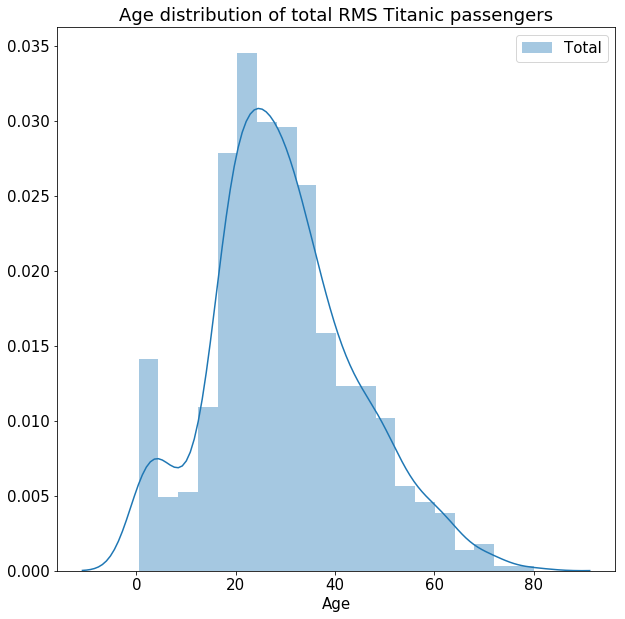

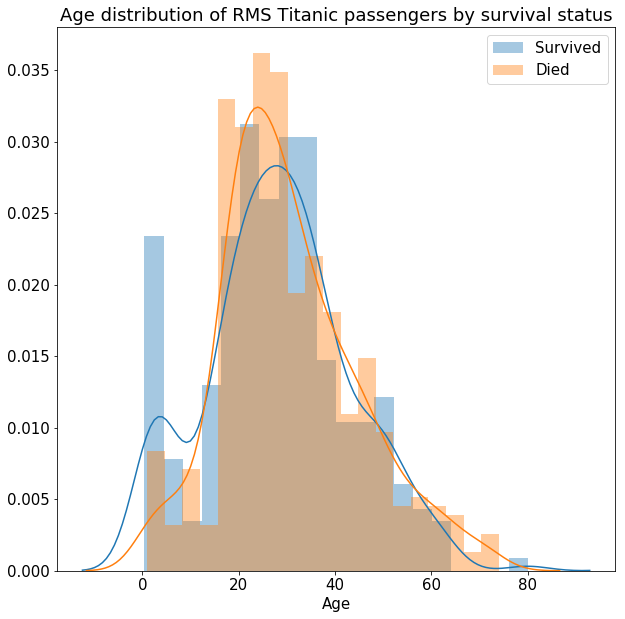

In [4]:
age = df[df['Age'].notnull()]['Age'].values
age_survived = df[(df['Survived'] == 1) & (df['Age'].notnull())]['Age'].values
age_died = df[(df['Survived'] == 0) & (df['Age'].notnull())]['Age'].values

plt.figure(figsize = (10, 10))
plt.rcParams['font.size'] = 15
sns.distplot(age, bins = 20, label = 'Total', norm_hist = True)
plt.title('Age distribution of total RMS Titanic passengers')
plt.legend()
plt.xlabel('Age')
plt.show()

plt.figure(figsize = (10, 10))
plt.rcParams['font.size'] = 15
sns.distplot(age_survived, bins = 20, label = 'Survived')
sns.distplot(age_died, bins = 20, label = 'Died')
plt.title('Age distribution of RMS Titanic passengers by survival status')
plt.legend()
plt.xlabel('Age')
plt.show()

Below, I impute null age values with a random integer between the 25th and 75th percentiles of the age feature. 

In [5]:
perc_25 = int(np.percentile(df[df['Age'].notnull()]['Age'].values, 25))

perc_75 = int(np.percentile(df[df['Age'].notnull()]['Age'].values, 75))

df['Age'] = [age if math.isnan(age) == False else random.randint(perc_25, perc_75) for age in df['Age']]

df = df.rename(columns = {'Age': 'age'})

df.head(n = 10)

,Survived,Pclass,Name,Sex,age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,20.0,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


A visual analysis of fare and fare by survival shows that fare will likely be a significant factor for survival. The distribution of fare for deceased passengers is highly leptokurtic and it falls significantly below the distribution of fare for survivors on the right side of the distribution- which, based on the direction of the x-axis, signals that survivors often paid substantially more than deceased passengers. Overall, this distribution is highly skewed to the left, and the distribution for each classification is leptokurtic. Although there are high fare values which resemble outliers, these values are *naturally occuring* and, therefore, will not be removed or modified.

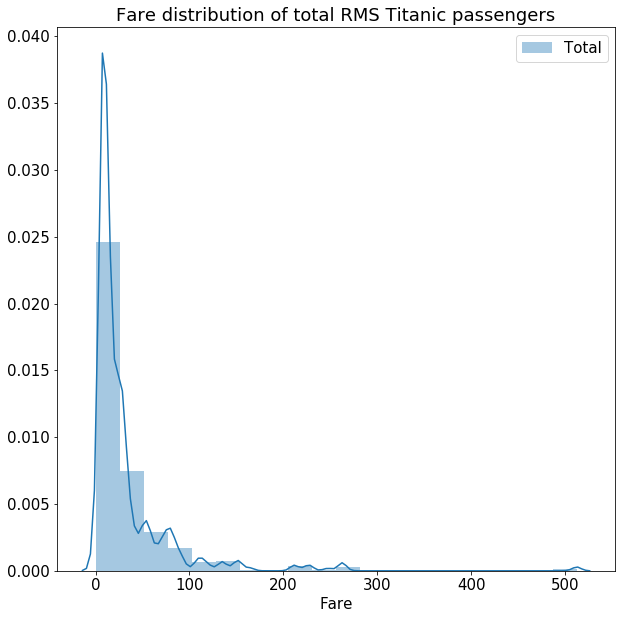

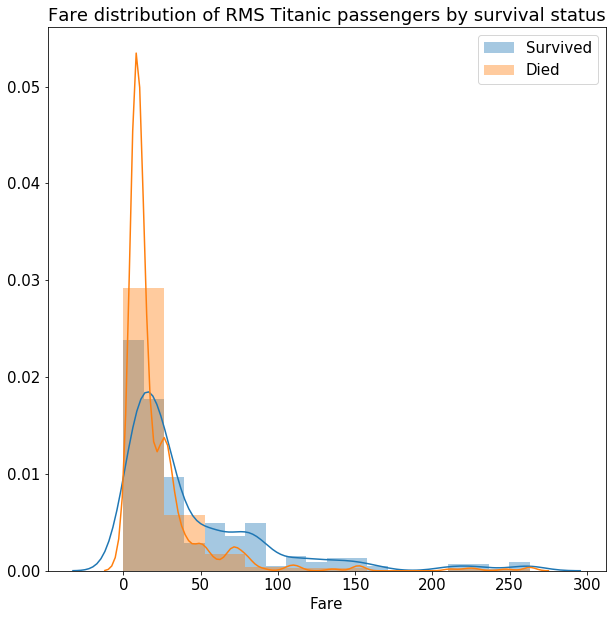

In [6]:
fare = df[df['Fare'].notnull()]['Fare'].values
fare_survived = df[(df['Survived'] == 1) & (df['Fare'].notnull()) & (df['Fare'] < 450)]['Fare'].values
fare_died = df[(df['Survived'] == 0) & (df['Fare'].notnull()) & (df['Fare'] < 450)]['Fare'].values

plt.figure(figsize = (10, 10))
plt.rcParams['font.size'] = 15
sns.distplot(fare, bins = 20, label = 'Total', norm_hist = True)
plt.title('Fare distribution of total RMS Titanic passengers')
plt.legend()
plt.xlabel('Fare')
plt.show()

plt.figure(figsize = (10, 10))
plt.rcParams['font.size'] = 15
sns.distplot(fare_survived, bins = 20, label = 'Survived')
sns.distplot(fare_died, bins = 10, label = 'Died')
plt.title('Fare distribution of RMS Titanic passengers by survival status')
plt.legend()
plt.xlabel('Fare')
plt.show()

Given the skew of the distribution for fare, this feature is probably a good candidate for log transformation. Since log base ten of zero cannot be computed, fare values equal to zero are skipped using a simple for loop which log transforms every fare value not equal to zero.

In [7]:
df = df.rename(columns = {'Fare': 'fare'})

fare = []

for i in range(df.index[0], len(df) + 1):
    
    value = df['fare'][i]
    
    if value != 0:
        
        fare.append(np.log(value))
        
    else:
        
        fare.append(0)
        
df['fare'] = fare

The log transformation did not cause the distribution of fare to closely resemble a normal distribution; however, it is less skewed than before. There are other transformations available, such as the Box-Cox transformation; however, it is difficult to make up for a messy distribution, like the one below. I will leave this alone for now.

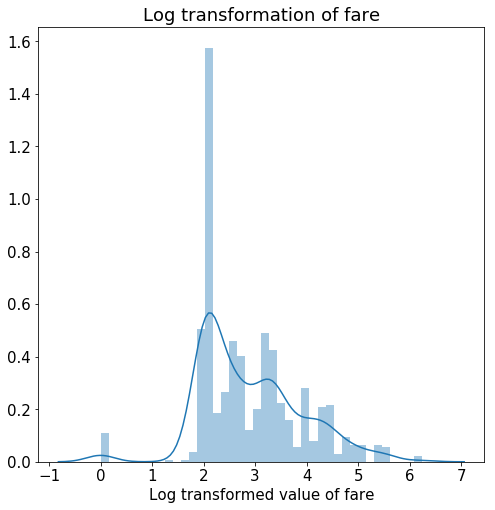

In [8]:
plt.figure(figsize = (8, 8))
sns.distplot(df['fare'].values, bins = 40)
plt.title("Log transformation of fare")
plt.xlabel("Log transformed value of fare")
plt.show()

Many (though, not all) ML algorithms perform best with standardized data scaled to unit variance with the mean removed. The equation for this transformation is simple. It is given by the below equation where 'z' represents the score of an individual sample. 

In [9]:
Math(r'z = (x - u) / s')

<IPython.core.display.Math object>

Scaling the fare and age features using the above equation via sklearn's standard scaler module. There are numerous standardization modules available, such as min-max scaling, et cetera which are sometimes appropriate for data with outliers and non-normal distributions. However, this notebook employs the standard scaler module for simplicity's sake.

In [10]:
fare = df['fare'].values.reshape(-1, 1)

age = df['age'].values.reshape(-1, 1)

scaler = StandardScaler()

scaler.fit(fare)

fare = scaler.transform(fare)

scaler.fit(age)

age = scaler.transform(age)

df['fare'] = fare

df['age'] = age

Next, since many (though, not all) machine learning algorithms cannot handle categorical features which exceed two classes (0 and 1), the three pclass categories are separated into unique features.

In [11]:
pclass = pd.get_dummies(df['Pclass'], prefix = 'pclass')

df = pd.merge(left = df, right = pclass, how = 'inner', left_index = True, right_index = True)

df.drop('Pclass', axis = 1, inplace = True)

df.head(n = 10)

,Survived,Name,Sex,age,SibSp,Parch,Ticket,fare,Cabin,Embarked,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",male,-0.567413,1,0,A/5 21171,-0.910717,NaN,S,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.641499,1,0,PC 17599,1.369616,C85,C,1,0,0
3,1,"Heikkinen, Miss. Laina",female,-0.265185,0,0,STON/O2. 3101282,-0.821904,NaN,S,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.414828,1,0,113803,1.075818,C123,S,1,0,0
5,0,"Allen, Mr. William Henry",male,0.414828,0,0,373450,-0.806291,NaN,S,0,0,1
6,0,"Moran, Mr. James",male,-0.718527,0,0,330877,-0.756930,NaN,Q,0,0,1
7,0,"McCarthy, Mr. Timothy J",male,1.850412,0,0,17463,1.052292,E46,S,1,0,0
8,0,"Palsson, Master. Gosta Leonard",male,-2.078553,3,1,349909,0.153882,NaN,S,0,0,1
9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,-0.189628,0,2,347742,-0.482778,NaN,S,0,0,1


ML algorithms need numeric values, so string values for gender are modified to binary classes of 0 and 1. 

In [12]:
df['Sex'] = [1 if sex == 'male' else 0 for sex in df['Sex']]

df = df.rename(columns = {'Sex': 'sex'})

df.head(n = 10)

,Survived,Name,sex,age,SibSp,Parch,Ticket,fare,Cabin,Embarked,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",1,-0.567413,1,0,A/5 21171,-0.910717,NaN,S,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.641499,1,0,PC 17599,1.369616,C85,C,1,0,0
3,1,"Heikkinen, Miss. Laina",0,-0.265185,0,0,STON/O2. 3101282,-0.821904,NaN,S,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.414828,1,0,113803,1.075818,C123,S,1,0,0
5,0,"Allen, Mr. William Henry",1,0.414828,0,0,373450,-0.806291,NaN,S,0,0,1
6,0,"Moran, Mr. James",1,-0.718527,0,0,330877,-0.756930,NaN,Q,0,0,1
7,0,"McCarthy, Mr. Timothy J",1,1.850412,0,0,17463,1.052292,E46,S,1,0,0
8,0,"Palsson, Master. Gosta Leonard",1,-2.078553,3,1,349909,0.153882,NaN,S,0,0,1
9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,-0.189628,0,2,347742,-0.482778,NaN,S,0,0,1


We previously observed that only 204 cabin values are not null; this means that about about 78% of all cabin values *are* null. Under other circumstances, it might be interesting to parse these cabin values by the first value (which is an alphabetic letter) in order to indicate cabin position on this ship (which is probably meaningful data). However, due to the frequency of null values, it is unlikely that ML algorithms can learn from extra feature engineering based on this feature. Instead of deleting this feature completely, however, I classify instances of null cabin values with 1 and non-null values with 0 since missing values might not be entirely random. My correlation analysis in the latter part of this notebook show that null cabin values are *not* entirely random. In fact, they correlate with first class passengers who typically do not have missing cabin values.

In [13]:
df['Cabin'] = np.where(df['Cabin'].isnull(), 1, 0)

df = df.rename(columns = {'Cabin': 'cabin'})

df.head(n = 10)

,Survived,Name,sex,age,SibSp,Parch,Ticket,fare,cabin,Embarked,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",1,-0.567413,1,0,A/5 21171,-0.910717,1,S,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.641499,1,0,PC 17599,1.369616,0,C,1,0,0
3,1,"Heikkinen, Miss. Laina",0,-0.265185,0,0,STON/O2. 3101282,-0.821904,1,S,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.414828,1,0,113803,1.075818,0,S,1,0,0
5,0,"Allen, Mr. William Henry",1,0.414828,0,0,373450,-0.806291,1,S,0,0,1
6,0,"Moran, Mr. James",1,-0.718527,0,0,330877,-0.756930,1,Q,0,0,1
7,0,"McCarthy, Mr. Timothy J",1,1.850412,0,0,17463,1.052292,0,S,1,0,0
8,0,"Palsson, Master. Gosta Leonard",1,-2.078553,3,1,349909,0.153882,1,S,0,0,1
9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,-0.189628,0,2,347742,-0.482778,1,S,0,0,1


There are only two missing values from the 'Embarked' feature. Therefore, I impute these values with the most frequently occuring value- which is 'S'. Two missing values is nothing to split hairs over in this circumstance. Next, as aforementioned, since ML algorithms cannot process non-numeric values, and since most ML algorithms do not handle categorical features easily, I create three dummy variables based on the 'Embarked' feature.

In [14]:
df['Embarked'] = ['S' if emb not in ['S', 'C', 'Q'] else emb for emb in df['Embarked']]

emb = pd.get_dummies(df['Embarked'], prefix = 'embarked').set_index(df.index)

df.drop('Embarked', axis = 1, inplace = True)

df = pd.merge(left = df, right = emb, how = 'inner', left_index = True, right_index = True)

df = df.rename(columns = {'embarked_S': 'embarked_s', 'embarked_C': 'embarked_c', 'embarked_Q': 'embarked_q'})

df.head(n = 10)

,Survived,Name,sex,age,SibSp,Parch,Ticket,fare,cabin,pclass_1,pclass_2,pclass_3,embarked_c,embarked_q,embarked_s
PassengerId,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",1,-0.567413,1,0,A/5 21171,-0.910717,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.641499,1,0,PC 17599,1.369616,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",0,-0.265185,0,0,STON/O2. 3101282,-0.821904,1,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.414828,1,0,113803,1.075818,0,1,0,0,0,0,1
5,0,"Allen, Mr. William Henry",1,0.414828,0,0,373450,-0.806291,1,0,0,1,0,0,1
6,0,"Moran, Mr. James",1,-0.718527,0,0,330877,-0.756930,1,0,0,1,0,1,0
7,0,"McCarthy, Mr. Timothy J",1,1.850412,0,0,17463,1.052292,0,1,0,0,0,0,1
8,0,"Palsson, Master. Gosta Leonard",1,-2.078553,3,1,349909,0.153882,1,0,0,1,0,0,1
9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,-0.189628,0,2,347742,-0.482778,1,0,0,1,0,0,1


Next, I calculate family size based on the sum of 'SibSp' and 'Parch'.

In [15]:
family_size = df['SibSp'] + df['Parch']

family_size = pd.get_dummies(family_size, prefix = 'family_size')

df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

df = pd.merge(left = df, right = family_size, how = 'inner', left_index = True, right_index = True)

df.head(n = 10)

,Survived,Name,sex,age,Ticket,fare,cabin,pclass_1,pclass_2,pclass_3,...,embarked_s,family_size_0,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_10
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",1,-0.567413,A/5 21171,-0.910717,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.641499,PC 17599,1.369616,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,"Heikkinen, Miss. Laina",0,-0.265185,STON/O2. 3101282,-0.821904,1,0,0,1,...,1,1,0,0,0,0,0,0,0,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.414828,113803,1.075818,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
5,0,"Allen, Mr. William Henry",1,0.414828,373450,-0.806291,1,0,0,1,...,1,1,0,0,0,0,0,0,0,0
6,0,"Moran, Mr. James",1,-0.718527,330877,-0.756930,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7,0,"McCarthy, Mr. Timothy J",1,1.850412,17463,1.052292,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
8,0,"Palsson, Master. Gosta Leonard",1,-2.078553,349909,0.153882,1,0,0,1,...,1,0,0,0,0,1,0,0,0,0
9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,-0.189628,347742,-0.482778,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0


One of the most interesting features in this data is the 'Name' feature, which contains the names of every passenger. Since each sample contains a surname, it might be worth parsing these strings in order to one hot encode these surnames into unique features- which the below script does. In addition, since there are some titles which do not appear very often (and they correlate with wealthy titles), it makes mathematical sense to group these titles into a single feature called 'rich_name' because features which are mostly one value, such as zero, are difficult to learn from.

In [16]:
title = df['Name'].str.split(', ').str[1].str.split(' ').str[0]

title.replace({'Capt.': 'rich_name', 'Col.': 'rich_name', 'Don.': 'rich_name', 
               
               'Dr.': 'rich_name', 'Jonkheer.': 'rich_name', 'Lady.': 'rich_name',
               
               'Major.': 'rich_name', 'Mlle.': 'rich_name', 'Mme.': 'rich_name', 
              
               'Rev.': 'rich_name', 'Sir.': 'rich_name', 'the': 'rich_name', 
               
               'Ms.': 'rich_name'}, inplace = True)

df.drop('Name', axis = 1, inplace = True)

title = pd.get_dummies(title)

df = pd.merge(left = df, right = title, how = 'inner', left_index = True, right_index = True)

df.head(n = 10)

,Survived,sex,age,Ticket,fare,cabin,pclass_1,pclass_2,pclass_3,embarked_c,...,family_size_4,family_size_5,family_size_6,family_size_7,family_size_10,Master.,Miss.,Mr.,Mrs.,rich_name
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,-0.567413,A/5 21171,-0.910717,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0.641499,PC 17599,1.369616,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,0,-0.265185,STON/O2. 3101282,-0.821904,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0.414828,113803,1.075818,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,1,0.414828,373450,-0.806291,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,0,1,-0.718527,330877,-0.756930,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7,0,1,1.850412,17463,1.052292,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,1,-2.078553,349909,0.153882,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
9,1,0,-0.189628,347742,-0.482778,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


The 'Ticket' feature is deleted because the naming convention for ticket stubs is highly inconsistent and, therefore, very little feature engineering can be done to make this feature useful.

In [17]:
df.drop('Ticket', axis = 1, inplace = True)

Certain features are comprised of mostly zero's. Features at or less than approximately 3% of non null values should probably be deleted entirely.

In [18]:
for i in range(1, len(df.columns)):
    
    value = df[df.columns[i]].sum()
    
    print(df.columns[i], " ", value / len(df) * 100)

sex   64.75869809203144
age   1.515186529679226e-14
fare   -6.8283077159886166e-15
cabin   77.10437710437711
pclass_1   24.242424242424242
pclass_2   20.65095398428732
pclass_3   55.106621773288445
embarked_c   18.855218855218855
embarked_q   8.641975308641975
embarked_s   72.50280583613917
family_size_0   60.26936026936027
family_size_1   18.069584736251404
family_size_2   11.447811447811448
family_size_3   3.254769921436588
family_size_4   1.6835016835016834
family_size_5   2.4691358024691357
family_size_6   1.3468013468013467
family_size_7   0.6734006734006733
family_size_10   0.7856341189674524
Master.   4.489337822671156
Miss.   20.42648709315376
Mr.   58.0246913580247
Mrs.   14.029180695847362
rich_name   3.0303030303030303


There are not many families larger than 3 or 4 members in total, so I group these family sizes into a single feature in order to reduce the number of overall features; this helps to reduce the overall dimensionality of this dataset.

In [19]:
df['large_family'] = df['family_size_10'] + df['family_size_7'] + df['family_size_6'] + df['family_size_5'] + df['family_size_4'] + df['family_size_3']

These features are no longer necessary since they have been categorized into a single feature.

In [20]:
df.drop(['family_size_10', 'family_size_7', 'family_size_6', 
         
         'family_size_5', 'family_size_4', 'family_size_3'], axis = 1, inplace = True)

'rich_name' does not contain very much data either. Therefore, it is deleted in order to further reduce the dimensionality of this dataset.

In [21]:
df.drop('rich_name', axis = 1, inplace = True)

Unsurprisingly, the 'Mr.' feature is strongly correlated with sex. Although there are not steadfast rules about what is considered a high or low correlation, ~87% implies this variable is redudant and can probably be predicted using linear combinations of other variables in this dataset to a startling degree. Aside from this feature, the below correlation values seem acceptable. Conceptually, it might seem like the other title features correlate strongly with the sex feature and, therefore ought to be deleted, however, these features are actually not perfect linear combinations of other variables like class and/or sex. To put it one way, although every Miss. and Mrs. is female, not every female is a Miss. or Mrs. It makes good sense to keep them.

In [22]:
df.corr()

,Survived,sex,age,fare,cabin,pclass_1,pclass_2,pclass_3,embarked_c,embarked_q,embarked_s,family_size_0,family_size_1,family_size_2,Master.,Miss.,Mr.,Mrs.,large_family
Survived,1.000000,-0.543351,-0.066376,0.331805,-0.316912,0.285904,0.093349,-0.322308,0.168240,0.003650,-0.149683,-0.203367,0.163157,0.143869,0.085221,0.327093,-0.549199,0.339040,-0.029945
sex,-0.543351,1.000000,0.071546,-0.264751,0.140391,-0.098013,-0.064746,0.137143,-0.082853,-0.074115,0.119224,0.303646,-0.184774,-0.096322,0.159934,-0.686808,0.867334,-0.547600,-0.154624
age,-0.066376,0.071546,1.000000,0.101433,-0.226539,0.308752,0.011321,-0.275235,0.028896,0.003999,-0.027830,0.178715,0.052973,-0.089667,-0.368457,-0.229850,0.171994,0.162691,-0.261821
fare,0.331805,-0.264751,0.101433,1.000000,-0.561192,0.668765,-0.031956,-0.550203,0.261367,-0.164816,-0.125249,-0.485150,0.271151,0.158149,0.096656,0.109390,-0.309771,0.217588,0.273166
cabin,-0.316912,0.140391,-0.226539,-0.561192,1.000000,-0.788773,0.172413,0.539291,-0.208528,0.129572,0.101139,0.158029,-0.202288,-0.047372,0.027841,-0.035314,0.137319,-0.118300,0.051471
pclass_1,0.285904,-0.098013,0.308752,0.668765,-0.788773,1.000000,-0.288585,-0.626738,0.296423,-0.155342,-0.161921,-0.113364,0.210796,-0.005982,-0.084700,0.012204,-0.097288,0.088207,-0.078359
pclass_2,0.093349,-0.064746,0.011321,-0.031956,0.172413,-0.288585,1.000000,-0.565210,-0.125416,-0.127301,0.189980,-0.039070,0.005419,0.086523,0.009903,-0.024652,-0.088569,0.121239,-0.034722
pclass_3,-0.322308,0.137143,-0.275235,-0.550203,0.539291,-0.626738,-0.565210,1.000000,-0.153329,0.237449,-0.015104,0.129472,-0.186032,-0.065263,0.064918,0.009548,0.155907,-0.174671,0.095773
embarked_c,0.168240,-0.082853,0.028896,0.261367,-0.208528,0.296423,-0.125416,-0.153329,1.000000,-0.148258,-0.782742,-0.095298,0.153941,0.033954,-0.035225,0.026215,-0.072567,0.061395,-0.077301
embarked_q,0.003650,-0.074115,0.003999,-0.164816,0.129572,-0.155342,-0.127301,0.237449,-0.148258,1.000000,-0.499421,0.086464,-0.051009,-0.035313,0.010478,0.171117,-0.078338,-0.089739,-0.037780


'Mr.' is deleted as a feature.

In [23]:
df.drop(['Mr.'], axis = 1, inplace = True)

### Model selection.
<br>

<br>

There are many machine learning algorithms for classification to choose from. Each of these algorithms, however, have specific uses and assumptions. Logistic Regression, for example, is a popular classification algorithm that assumes normality- an assumption which this dataset clearly violates. Other classification algorithms, like Logistic Regression and Stochastic Gradient Descent, typically require *many* samples- which clearly does not apply to this dataset either. Therefore, another classification model is required for the specific use case in this notebook. A model that can make classifications based on non-normal training data with very few samples is ideal. Ensemble methods are one category of classification algorithms which meet this criteria. In particular, the Random Forest Classification algorithm sticks out. The Random Forest Classifier does not assume normality nor does it require feature sclaing. In fact, this algorithm can even handle categorical variables. It does not require large sample sizes either. Essentially, this algorithm works by making predictions based on averaging the probabilistic predictions generated by many randomized decision trees. However, this algorithm is known to overfit data when sample sizes are small. It will be important, therefore, to tune the hyperparameters of this model. 
<br>

<br>


### Testing, hyperparameter tuning, and model evaluation.
<br>

Separating the independent and dependent features as separate numpy arrays.

In [24]:
X = df[df.columns[1:]].values

y = df['Survived'].values

Since GridSearchCV increases the number of cross validations exponentially, the RandomizedSearchCV module is employed in order to reduce training time. For a production level model that would be deployed for solving real world problems, this module might be inadequate. Regardless, for now, I pass lists of values for the n_estimators, max_features, and max_depth parameters. 

In [25]:
n_estimators_range = [i * 500 for i in range(1, 9)]

max_features_range = [i for i in range(1, 17)]

max_depth_range = [i + 1 for i in range(0, 20)]

bootstrap_range = ['True', 'False']

param_grid = dict(n_estimators = n_estimators_range, 
                  
                  max_features = max_features_range, 
                  
                  max_depth = max_depth_range,
                 
                  bootstrap = bootstrap_range)

rfc = RandomForestClassifier()

rand = RandomizedSearchCV(rfc, param_grid, cv = 10, scoring = 'accuracy', n_jobs = -1, n_iter = 10, random_state = 5)

rand.fit(X, y)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'bootstrap': ['True', 'False']},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

Assigning these hyperparameters to unique objects.

In [26]:
best_n_estimators = rand.best_params_['n_estimators']

best_max_features = rand.best_params_['max_features']

best_max_depth = rand.best_params_['max_depth']

best_bootstrap = rand.best_params_['bootstrap']

Applying the hyperparameters to the Random Forest Model and making predictions based on a randomly selected partition of about 30% of the dataset for final testing. The results are quite good. ~85.45 is a strong accuracy score.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

rfc = RandomForestClassifier(n_estimators = best_n_estimators, 
                             
                             max_features = best_max_features, 
                             
                             max_depth = best_max_depth,
                            
                             bootstrap = best_bootstrap)

rfc.fit(X_train, y_train)

pred = rfc.predict(X_test)

rfc.score(X_test, y_test) * 100

85.44776119402985

Unsurprisingly, gender, fare, and age are some of the most important features according to the Random Forest Classifier. Cabin also appears to be quite significant.

In [28]:
pd.DataFrame(rfc.feature_importances_, columns = ['rank'], index = df.columns[1:]).sort_values(
    
    'rank', ascending = False)

,rank
sex,0.351903
age,0.158005
fare,0.154046
pclass_3,0.097987
cabin,0.074555
large_family,0.025957
Master.,0.020704
Miss.,0.018281
Mrs.,0.016824
pclass_1,0.016803


The below confusion matrix shows this model made more erroneous predictions of death than erroneous predictions of survival. It is very likely this is due to anomolous male survivors who likely fought to survive or managed to cling onto debri before the ship completely submerged into the ocean.

In [29]:
pd.DataFrame(confusion_matrix(y_test, pred), 
             
             columns = ['Predicted Death', 'Predicted Survival'], 
            
             index = ['Actual Death', 'Actual Survival'])

,Predicted Death,Predicted Survival
Actual Death,148,18
Actual Survival,21,81
